Our goal is to simulate a isothermal sphere undergoing gravitational collapse. We can write down the force balance equation for the sphere, which describes the competition between gravitational infall versus thermal pressure support.
$$ -\frac{1}{\rho}\nabla P -\nabla \Phi_g =0$$
Using Poisson's equation ($\nabla \Phi_g^2 =4\pi G \rho$) and the isothermal equation of state ($P = \rho a_T^2$), we can rearrange the equation to the form of the isothermal Lane-Emden equation: 


$$\frac{1}{\psi^2} \frac{d}{d\psi}\Bigg(\xi^2 \frac{d\psi}{d\xi}\Bigg)=e^{-\psi}$$
Using product rule, we can rewrite the Lane-Emden equation as: 
\begin{align}
\frac{d^2\psi}{d\xi^2}+\frac{2}{\xi}\frac{d\psi}{d\xi}=e^{-\psi}
\end{align}
with boundary conditions as: $\psi(0)=0$ and $\frac{d\psi}{d\xi}(0)=0$.

The Lane-Emden equation describes a family of solution based on the single parameter $\xi_{max}$, which specifies the cloud radius and determine the density contrast $\rho_c/\rho_0$ (ratio between central density and edge of the sphere). Analytically, the sphere is marginally stable (i.e. just at the verge of collpasing) when $\rho_c/\rho_0$=14.1 [1]. This marginally-stable state is called the Bonner-Ebert sphere. Numerically, we can see that a cloud radius of  $\xi$=6.451 corresponds to a density contrast of $\rho_c/\rho_0$=14.038. The singular isothermal sphere case corresponds to $\xi_{max}=\infty$. 

We want to solve the Lane-Emden equation to figure out what is the density distribution that yields a marginally-stable sphere, but the Lane-Emden solution can not be solved in closed form, so instead we need to do numerical intergration to get the solution. 

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We start integrating at a small poisitive number (1e-6) to avoid div-by-0 error and integrate up to xi_max, with interval of $\Delta \xi$ = 0.01.

In [79]:
xi_max = 6.451
from scipy import integrate
def solvr(Y, t):
    return [Y[1], exp(-Y[0])-2/t*Y[1]]
xi = np.arange(1e-6, xi_max, 0.01)
IC = [0, 0] # initial conditions for psi and psi prime
psi = integrate.odeint(solvr, IC, xi)

For a spherically symmetric cloud, $\rho(r)=\rho_c e^{-\psi}$, so we can use the numerically integrated results for $\psi$ to compute the density profile.

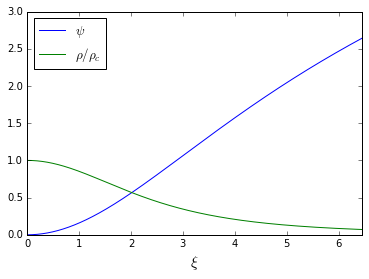

In [65]:
rho = np.exp(-psi[:,0]) 
plt.plot(xi,psi[:,0],label ='$\psi$')
plt.plot(xi,rho,label =r'$\rho/\rho_c$') 
plt.xlabel(r"$\xi$",fontsize=15)
plt.xlim(0,xi_max)
from matplotlib.legend_handler import HandlerLine2D
plt.legend(loc='upper left',prop={'size':13},numpoints=1)

Note that since ``rmax`` is the only parameter that needs to be adjusted for different models of the Lane-Emden solution. To make sure that the boundary of the sphere is properly filled with the Bonnert-Ebert values, we extend the density profile in ``density.txt`` to $\xi$= 20. 

In [80]:
xi = np.arange(1e-6, 20, 0.01) 
psi = integrate.odeint(solvr, IC, xi)
rho = np.exp(-psi[:,0]) 
np.savetxt("FLASH_4.3/density.txt",rho)

Now we have a 1D array of non-dimensional density values from numerical integration, we need to assign each cell in the simulation box with the density values that corresponds to the right $\rho(r)$. Since we are working with a radial distribution on a cartesian grid, we don't have the exact radius value at each cell, so need to do linear interpolation to map the cells to somewhere between their closest density values. As explained by [Wikipedia](https://en.wikipedia.org/wiki/Linear_interpolation), linear interpolation basically weighs what the predicted values are, based on how close the x values lie to the previous and subseqeunt datapoints. In our case, 

$$ \rho(r) = \rho_0 + (\rho_1-\rho_0)\frac{r-r_0}{r_1-r_0}$$

Translating this into our Simulation_init.F90 and picking dr ($\Delta \xi$) as 0.01 to correspond with np.arange used in the numerical integration: 

    if (rc <= rmax) then
       rc0 = int(rc/dr)+1 !to prevent from hitting index 0 which is yields zero density
       rho0 =  rho_c*dens_arr(rc0,1)
       rho1 = rho_c*dens_arr(rc0+1,1)
       rc0 = rc0*dr
       rc1 = rc0+dr
       rhoZone = fattening_factor*(rho0+(rho1-rho0)*(rc-rc0)/(rc1-rc0) )!linear interpolation

Simulation_init.F90 reads in values up to ``rmax`` $\xi$= 16.90 for initialize the sphere, note that this has a much higher density contrast than the Bonner-Ebert sphere. This ensures that the sphere in our toy problem will actually collapse in a short time. We also multiply the sphere's density by a "fattening_factor" of 100 for the same reason.

In [97]:
idx = np.where(np.isclose(xi,16.9))[0][0]
print "At xi = ", xi[idx]
print "Density is: ", rho[idx]*rho_c, "g/cm^3"
print "density contrast is ", 1./rho[idx]

At xi =  16.900001
Density is:  7.2918475616e-20 g/cm^3
density contrast is  150.853400418


We can now run our simulation to check that the sphere is initialized with the right density distribution.

In [21]:
cd ~/dlee/FLASH4.3/object/

/global/u2/d/dorislee/dlee/FLASH4.3/object


In [30]:
import yt
from matplotlib.legend_handler import HandlerLine2D
from mpl_toolkits.axes_grid1 import AxesGrid
from yt.mods import *
yt.mylog.setLevel(50)

In [77]:
def compareplot1Dprofile(timestep):
    fattening_factor=100
    rho_c = 1.1e-19*fattening_factor
    pf= yt.load("sphere_hdf5_chk_{}".format(str(timestep).zfill(4)))
    sp = pf.sphere(pf.domain_center, (0.32,"pc"))
    rp = yt.create_profile(sp,'radius','density')
    plt.plot(rp.x.value*1.05e-17,rp["density"].in_units("g/cm**3").value/rho_c,label="Simulation")
    xi_max = 6.451
    def solvr(Y, t):
        return [Y[1], exp(-Y[0])-2/t*Y[1]]
    xi = np.arange(1e-6, xi_max, 0.01) #start at small poisitive number to avoid div-by-0
    psi = integrate.odeint(solvr, [0, 0], xi)
    rho = np.exp(-psi[:,0])  
    plt.plot(xi,rho,"--",label ='Integration',color="red",linewidth=5)
    plt.xlabel(r"$\xi$",fontsize=15)
    plt.ylabel(r"$\rho/\rho_c$",fontsize=15)
    plt.legend(loc='upper right',prop={'size':12},numpoints=1)

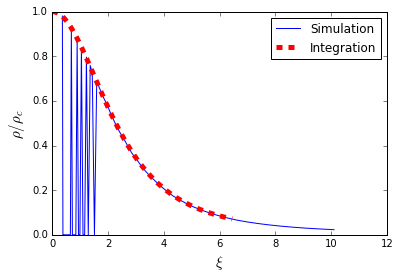

In [78]:
compareplot1Dprofile(0)

For more information on numerical integration using scipy see [Nathan Typanski's tutorial on solving the damped harmonic oscillator ODE](http://www.nathantypanski.com/blog/2014-08-23-ode-solver-py.html). 

In [101]:
rho[1690]*rho_c

7.2918475616032769e-20

In [ ]:
The problem setup 

In [ ]:
See FCSphere/ 

## Reference: 

[1] P. N. Foster, R. A. Chevalier. Gravitational Collapse of an Isothermal Sphere. ApJ 416, 303-311 (1993).

[2] R. B. Larson. Numerical Calculations of the Dynamics of a Collapsing Proto-Star. MNRAS 145, 271–295 (1969). [Link](http://mnras.oxfordjournals.org/content/145/3/271)